# The IoT Project begins!!

## The Caring Home / Helpful Home

We will develop a model that can estimate if an elderly person is safe in their home.

## Data Curation Part 1

Today we'll begin our scrubbing and curating our dataset..

The dataset is here:  
data/memory.json



In [21]:
# imports
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import json
import numpy as np
import random
from collections import Counter, defaultdict
import pickle


In [22]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [23]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [24]:
# One more import - the Item class
# If you get an error that you need to agree to Meta's terms when you run this, then follow the link it provides you and follow their instructions
# You should get approved by Meta within minutes
# Any problems - message me or email me!

from items import Item

In [25]:
%matplotlib inline

In [26]:
# Define the path to the JSON file
file_path = 'data/memory.json'

# Check if the file exists
if not os.path.exists(file_path):
    # Create a dummy dataset
    dummy_data = [{"situation": {"situation_description": "The elderly person displayed a concerning pattern of movement where they were in the bathroom for an extended period without any recorded exits. The bathroom was accessed multiple times, with the last entry indicating they entered without subsequent movement recorded. This prolonged occupancy may indicate a potential issue that requires monitoring, as it deviates from typical activity where movement between rooms is more frequent. Such behavior raises alarms about their safety and well-being.", "result": "anomalous", "start_timestamp": 1737986700, "end_timestamp": 1737987300, "details": ["{\"timestamp\": 1737986700, \"room\": \"bathroom\", \"nodeId\": 2, \"onOff\": true}", "{\"timestamp\": 1737987000, \"room\": \"bathroom\", \"nodeId\": 3, \"humidity\": 6500}", "{\"timestamp\": 1737987300, \"room\": \"bathroom\", \"nodeId\": 2, \"onOff\": false}"]}, "estimate": "anomalous"}]
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Write the dummy data to the JSON file
    with open(file_path, 'w') as file:
        json.dump(dummy_data, file)

# Open and read the JSON file
with open(file_path, 'r') as file:
    dataset = json.load(file)

# Print the data
print(dataset)

[{'situation': {'situation_description': 'During the observed timeframe, the movement pattern shows an elderly person repeatedly visiting the kitchen and bathroom areas followed by long periods of inactivity. Notably, there is a concerning absence of movement in common areas such as the living room and hall for extended durations, particularly evident when occupancy dropped to zero for periods. This lack of activity might indicate potential mobility issues or disengagement that may warrant closer monitoring.', 'result': 'anomalous', 'start_timestamp': 1737988800, 'end_timestamp': 1737991860, 'details': ['{"timestamp": 1737988800, "room": "livingroom", "nodeId": 1, "occupancy": 1}', '{"timestamp": 1737990000, "room": "livingroom", "nodeId": 2, "onOff": false}', '{"timestamp": 1737991200, "room": "hall", "nodeId": 1, "occupancy": 1}', '{"timestamp": 1737991800, "room": "porch", "nodeId": 1, "occupancy": 1}', '{"timestamp": 1737991860, "room": "hall", "nodeId": 1, "occupancy": 0}']}, 'est

In [27]:
print(f"Number of Investigations: {len(dataset):,}")

Number of Investigations: 13


In [8]:
# Investigate a particular datapoint
datapoint = dataset[0]


In [9]:
# Investigate

print(datapoint["situation"]["details"])
print(datapoint["situation"]["result"])
print(datapoint["situation"]["situation_description"])
print(datapoint["estimate"])


['{"timestamp": 1737988800, "room": "livingroom", "nodeId": 1, "occupancy": 1}', '{"timestamp": 1737990000, "room": "livingroom", "nodeId": 2, "onOff": false}', '{"timestamp": 1737991200, "room": "hall", "nodeId": 1, "occupancy": 1}', '{"timestamp": 1737991800, "room": "porch", "nodeId": 1, "occupancy": 1}', '{"timestamp": 1737991860, "room": "hall", "nodeId": 1, "occupancy": 0}']
anomalous
During the observed timeframe, the movement pattern shows an elderly person repeatedly visiting the kitchen and bathroom areas followed by long periods of inactivity. Notably, there is a concerning absence of movement in common areas such as the living room and hall for extended durations, particularly evident when occupancy dropped to zero for periods. This lack of activity might indicate potential mobility issues or disengagement that may warrant closer monitoring.
anomalous


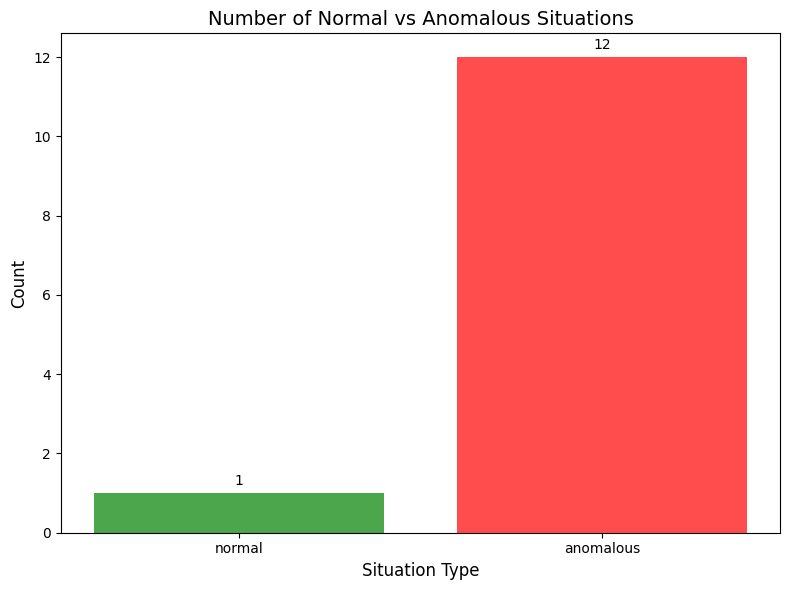

In [28]:
# Plot the distribution of results

# Count the occurrences of "normal" and "anomalous" results
situation_counts = {"normal": 0, "anomalous": 0}
for entry in dataset:
    result = entry.get("estimate", "unknown").lower()
    if result in situation_counts:
        situation_counts[result] += 1

# Extract keys and values for the bar chart
labels = list(situation_counts.keys())
counts = list(situation_counts.values())

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['green', 'red'], alpha=0.7)

# Add labels and title
plt.xlabel("Situation Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Number of Normal vs Anomalous Situations", fontsize=14)

# Annotate bars with counts
for i, count in enumerate(counts):
    plt.text(i, count + 0.2, str(count), ha='center', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [29]:
# So what is the first anomalous items??

for datapoint in dataset:
    try:
        estimate = datapoint["estimate"]
        if estimate == "anomalous":
            print(datapoint['situation']['situation_description'])
            break
    except ValueError as e:
        pass

During the observed timeframe, the movement pattern shows an elderly person repeatedly visiting the kitchen and bathroom areas followed by long periods of inactivity. Notably, there is a concerning absence of movement in common areas such as the living room and hall for extended durations, particularly evident when occupancy dropped to zero for periods. This lack of activity might indicate potential mobility issues or disengagement that may warrant closer monitoring.


## Now it's time to curate our dataset

We select all items

We will be create Item instances, which truncate the input and reasoning to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

## But why 1180 tokens??

This is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. 

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.



In [30]:
# Create an Item object for each with a result

items = []
for datapoint in dataset:
    try:
        estimate = datapoint["estimate"]
        if estimate == 'normal' or estimate == 'anomalous':
            item = Item(datapoint['situation'], estimate)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 13 items


In [31]:
# Look at the first item

items[0]

<$anomalous>

In [32]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[0].prompt)

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1737988800, "room": "livingroom", "nodeId": 1, "occupancy": 1}, {"timestamp": 1737990000, "room": "livingroom", "nodeId": 2, "onOff": false}, {"timestamp": 1737991200, "room": "hall", "nodeId": 1, "occupancy": 1}, {"timestamp": 1737991800, "room": "porch", "nodeId": 1, "occupancy": 1}, {"timestamp": 1737991860, "room": "hall", "nodeId": 1, "occupancy": 0}]


Result is anomalous


In [33]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[0].test_prompt())

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1737988800, "room": "livingroom", "nodeId": 1, "occupancy": 1}, {"timestamp": 1737990000, "room": "livingroom", "nodeId": 2, "onOff": false}, {"timestamp": 1737991200, "room": "hall", "nodeId": 1, "occupancy": 1}, {"timestamp": 1737991800, "room": "porch", "nodeId": 1, "occupancy": 1}, {"timestamp": 1737991860, "room": "hall", "nodeId": 1, "occupancy": 0}]


Result is 


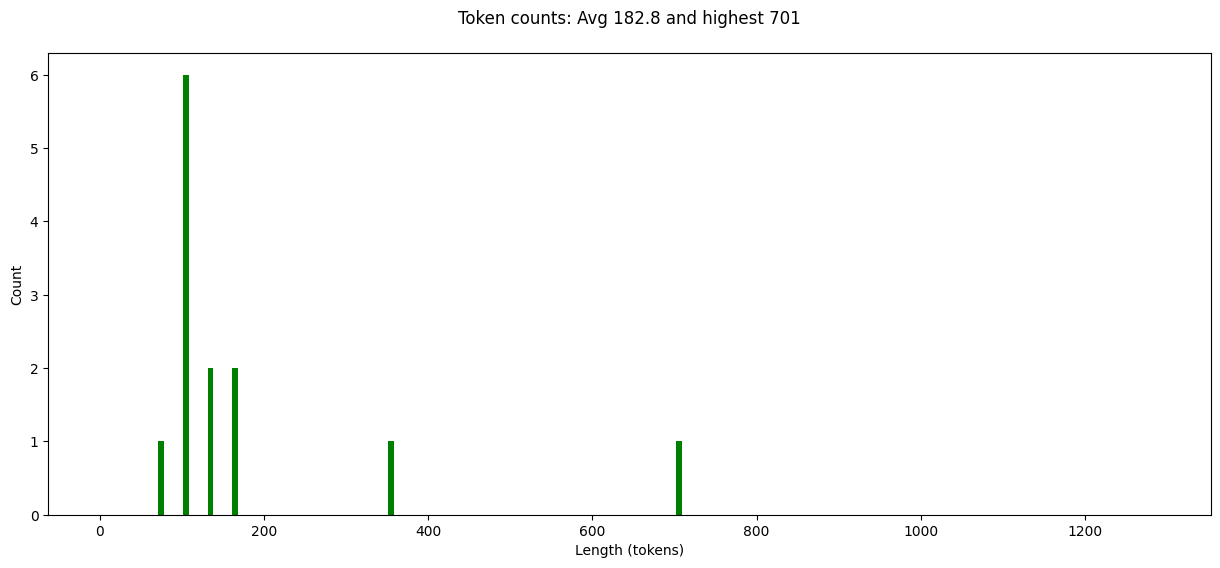

In [34]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 1300, 10))
plt.show()

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html

## Todos for you:

- Review the Item class and check you're comfortable with it
- Examine some Item objects, look at the training prompt with `item.prompt` and test prompt with `item.test_prompt()`
- Make some more histograms to better understand the data



# Finally
- Its time to break down our data into a training, test and validation dataset.
- Its typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. Well take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


Craft a dataset which is more balanced in terms of results. Try to balance out the categories - fewer anomalous items.

In [35]:
# Create a dict with a key of each result from normal to anomalous
# And in the result, put a list of items with that result (

slots = defaultdict(list)
for item in items:
    slots[item.result].append(item)

In [36]:
slots['normal']

[<$normal>]

In [37]:
# Create a dataset called "sample" which tries to more evenly take from the range of results
# And gives more weight to items from categories other than Anomalous
# Set random seed for reproducibility

# Note: we are not duplicating data here 

np.random.seed(42)
random.seed(42)
size=int(len(items)/2)
sample = []
for i in ['normal', 'anomalous']:
    slot = slots[i]
    weights = np.array([1 if item.result=='Normal' else 1 for item in slot])
    weights = weights / np.sum(weights)
    selected_indices = np.random.choice(len(slot), size=size, replace=True, p=weights)
    selected = [slot[i] for i in selected_indices]
    sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 12 items in the sample


In [38]:
train_end = int(len(sample)*0.80) # use 80% of the samples for train and 20% for test

random.seed(42)
random.shuffle(sample)
train = sample[:train_end]
test = sample[train_end:len(sample)]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 9 items and test set of 3 items


In [39]:
print(train)

[<$anomalous>, <$normal>, <$normal>, <$anomalous>, <$anomalous>, <$anomalous>, <$anomalous>, <$normal>, <$normal>]


In [40]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

## Now we have real training and test data that has come from RLHF? - Reinforcement Learning from Human Feedback
RLHF is a machine learning (ML) technique that uses human feedback to optimize ML models to self-learn more efficiently